In [1]:
import numpy as np
import pandas as pd

/tmp/ipykernel_17208/1662815981.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("./data/crop.yield.prediction.csv")
df

,crop,ton/ha_yield,rainfall,pesticides_tonnes,temperature,season
0,Tapioca (Cassava),20.5381,1034.0,75000.0,25.58,Rabi
1,Tapioca (Cassava),20.5381,975.0,75000.0,26.88,Kharif
2,Tapioca (Cassava),20.5381,989.0,75000.0,25.79,Kharif
3,Tapioca (Cassava),20.5381,940.0,75000.0,24.10,Rabi
4,Tapioca (Cassava),20.5381,1061.0,75000.0,25.25,Rabi
...,...,...,...,...,...,...
4043,Wheat,3.1538,835.0,45620.0,27.14,Rabi
4044,Wheat,3.1538,660.0,45620.0,25.98,Rabi
4045,Wheat,3.1538,711.0,45620.0,27.44,Rabi
4046,Wheat,3.1538,842.0,45620.0,27.44,Rabi


In [3]:
unique_crops = np.unique(df["crop"]).tolist()
seasons = np.unique(df["season"]).tolist()
unique_crops, seasons

(['Jowar',
  'Maize',
  'Potatoes',
  'Rice',
  'Soybeans',
  'Sweet potatoes',
  'Tapioca (Cassava)',
  'Wheat'],
 ['Kharif', 'Rabi'])

In [4]:
import seaborn as sns

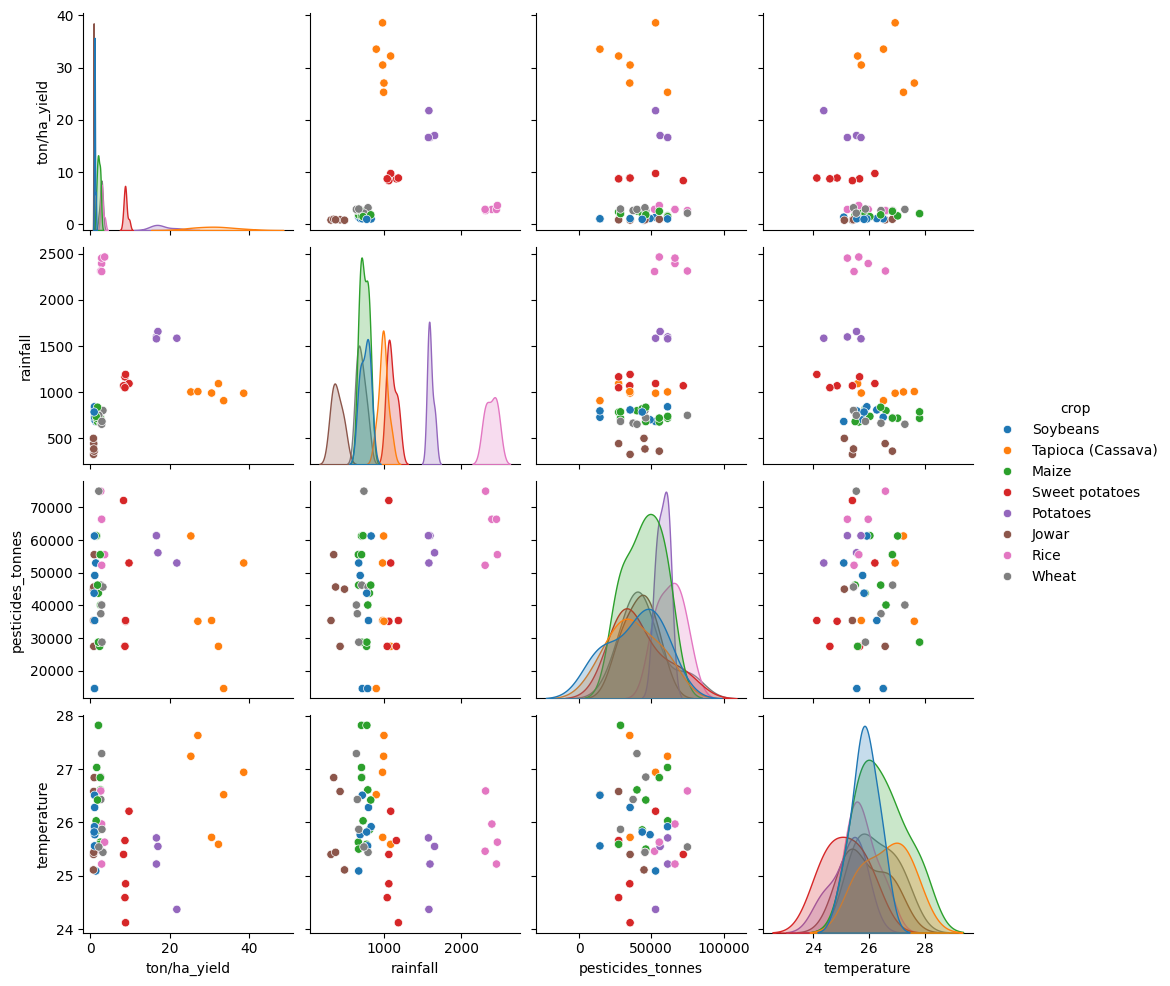

In [5]:
sns.pairplot(df.sample(n=50), hue="crop")

In [6]:
df["crop"] = df["crop"].map(lambda x: unique_crops.index(x))

In [7]:
df["season"] = df["season"].map(lambda x: seasons.index(x))

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
crop,4048.0,3.500000,2.291571,0.0000,1.750000,3.5000,5.2500,7.0000
ton/ha_yield,4048.0,8.088447,9.595022,0.6553,1.370475,2.8124,11.2471,38.5818
rainfall,4048.0,1093.814476,589.388891,300.0000,719.000000,874.5000,1293.0000,2474.0000
pesticides_tonnes,4048.0,48459.040000,14997.351972,14485.3300,37423.000000,46195.0000,61257.0000,75000.0000
temperature,4048.0,26.012589,0.909861,23.2600,25.460000,25.9800,26.6700,28.8500
season,4048.0,0.536808,0.498705,0.0000,0.000000,1.0000,1.0000,1.0000


In [9]:
from sklearn.model_selection import train_test_split

X = df.drop("ton/ha_yield", axis=1).to_numpy()
y = df["ton/ha_yield"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import time

def run_model(model, fit = True):
    begin = time.time()
    name = model.__class__.__name__

    if fit: 
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    ret = {}

    ret["MAE"] = mean_absolute_error(y_test, y_pred)
    ret["RMSE"] = mean_squared_error(y_test, y_pred, squared=False)
    ret["time"] = time.time() - begin


    fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
    ax[0].set_title(f"test vs predicted data - {name}")
    plot = sns.lineplot(y_test - y_pred, ax=ax[0])
    plot.set_xlabel("index in dataset")
    plot.set_ylabel("mean error")
    # sns.lineplot(y_pred, ax=ax[0])

    ax[1].set_title(f"absolute error (fraction) - {name}")
    sns.scatterplot(abs(y_pred - y_test) / y_pred, ax=ax[1], s=2).set_ylim(0, 2)


    return ret

> testing model: RandomForestRegressor


/home/smv/Code/fresh-fields/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  MAE:  0.00367
  RMSE: 0.0243
  time taken: 0.168s
> testing model: SVR


/home/smv/Code/fresh-fields/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smv/Code/fresh-fields/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  MAE:  6.71
  RMSE: 11.4
  time taken: 0.756s
> testing model: Ridge
  MAE:  7.16
  RMSE: 9.15
  time taken: 0.011s


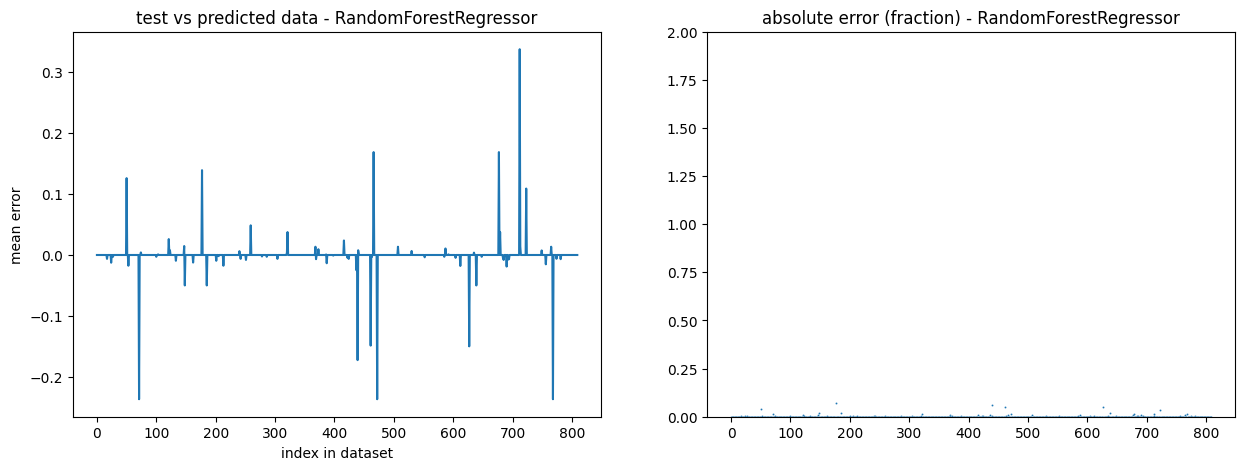

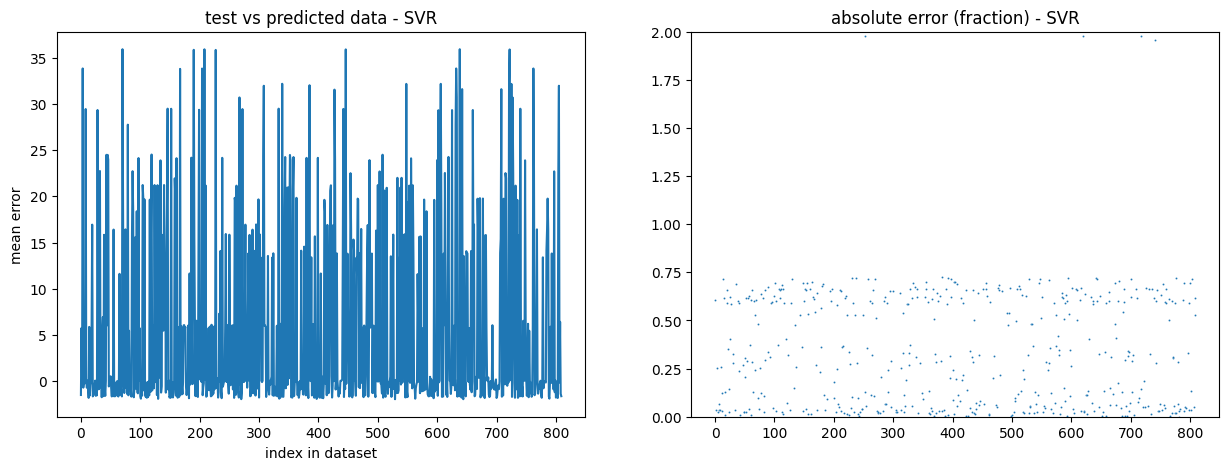

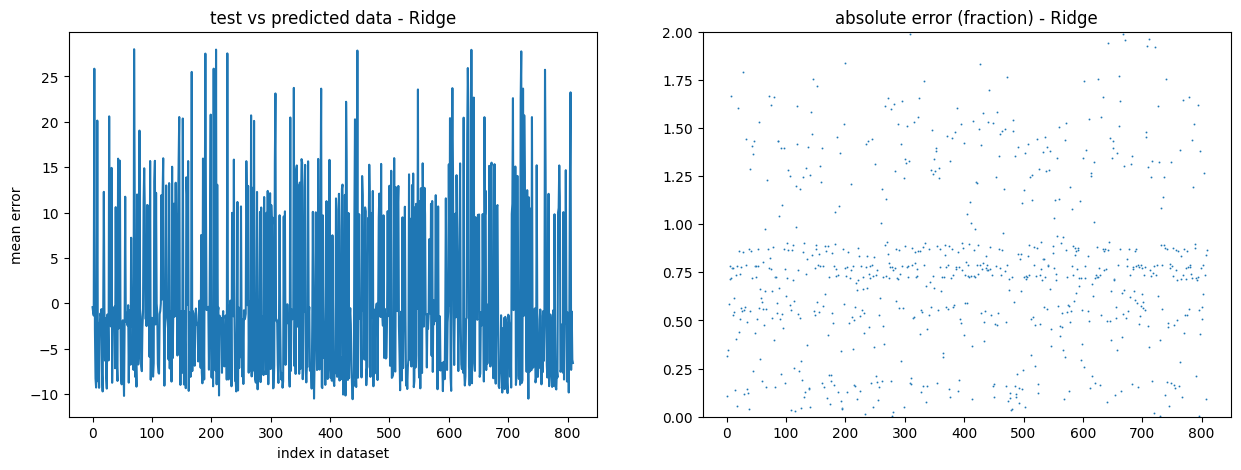

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge


regressors = [RandomForestRegressor(random_state=42,n_estimators=20),
              SVR(),
              Ridge(alpha=0.5)]

for model in regressors:
    print(f"> testing model: {model.__class__.__name__}")
    score = run_model(model)
    print(f"  MAE:  {score['MAE'] :.{3}}")
    print(f"  RMSE: {score['RMSE']:.{3}}")
    print(f"  time taken: {score['time']:.{3}}s")

In [12]:
from joblib import dump, load

In [13]:
dump(regressors[0], "./out/yield.prediction.joblib")

['./out/yield.prediction.joblib']

/home/smv/Code/fresh-fields/venv/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/smv/Code/fresh-fields/venv/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.3.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


  MAE:  0.00367
  RMSE: 0.0243
  time taken: 0.128s


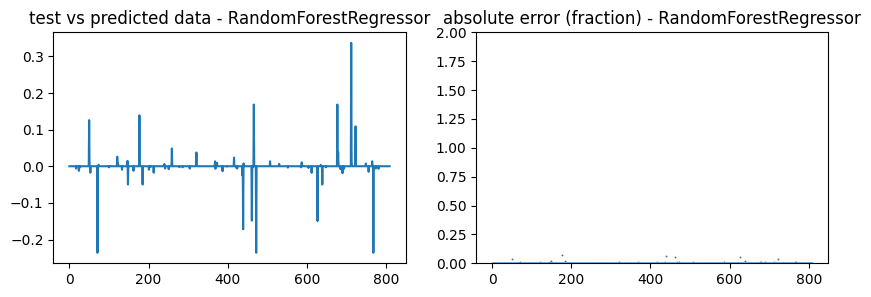

In [13]:
reg = load("./out/yield.prediction.joblib")

score = run_model(reg)
print(f"  MAE:  {score['MAE'] :.{3}}")
print(f"  RMSE: {score['RMSE']:.{3}}")
print(f"  time taken: {score['time']:.{3}}s")

In [15]:
reg

RandomForestRegressor(n_estimators=20, random_state=42)